In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Data Acquisition and Preprocessing
csv_file = "/content/drive/MyDrive/SafaricomAllStocks.csv"


In [ ]:
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Error: File '{csv_file}' not found.CSV file path is incorrect.")
    exit()

In [7]:
# Print the first few rows to inspect the data format
print(df.head())

       Date   Open   High   Low   Close    Volume
0  02/11/25  17.90  18.00  17.5   17.75   9072400
1  02/10/25  17.80  18.00  17.7   17.90   1848700
2  02/07/25  18.25  18.25  17.8   17.95   9991800
3  02/06/25  18.25  18.50  18.0   18.15  11395300
4  02/05/25  18.00  18.80  18.0   18.45  15718800


In [8]:
# Renaming columns to be consistent and easier to work with during programming the algorithms
df = df.rename(columns={
    " Date": "Date",
    " Open": "Open",
    " High": "High",
    " Low": "Low",
    " Close": "Close",
    " Volume": "Volume"
})

In [9]:
print(df.head())

       Date   Open   High   Low  Close    Volume
0  02/11/25  17.90  18.00  17.5  17.75   9072400
1  02/10/25  17.80  18.00  17.7  17.90   1848700
2  02/07/25  18.25  18.25  17.8  17.95   9991800
3  02/06/25  18.25  18.50  18.0  18.15  11395300
4  02/05/25  18.00  18.80  18.0  18.45  15718800


In [10]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-10-bc65fc4f2f4c>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [11]:
# Set the 'Date' column as the index
df = df.set_index('Date')

In [12]:
# Sort the data by date (earliest to latest) - important for time series analysis
df = df.sort_index()

In [13]:
# Checking for missing values before cleaning the dataset
print("\nMissing values before cleaning:\n", df.isnull().sum())


Missing values before cleaning:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


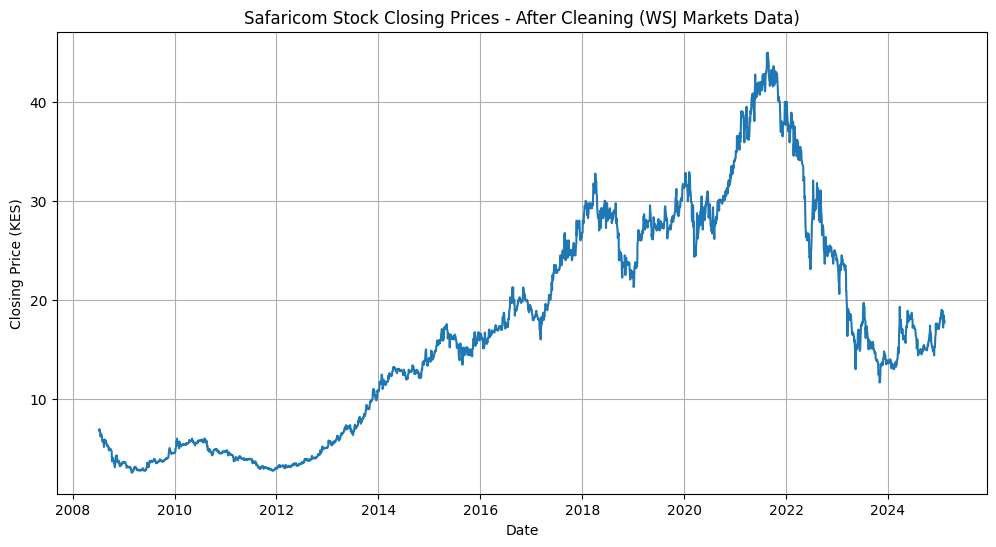

In [14]:
# Let's visualize the cleaned closing price since there are no missing values in the dataset
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Safaricom Stock Closing Prices - After Cleaning (WSJ Markets Data)')
plt.xlabel('Date')
plt.ylabel('Closing Price (KES)')
plt.grid(True)
plt.show()

# Data Distribution Visualization after cleaning the dataset

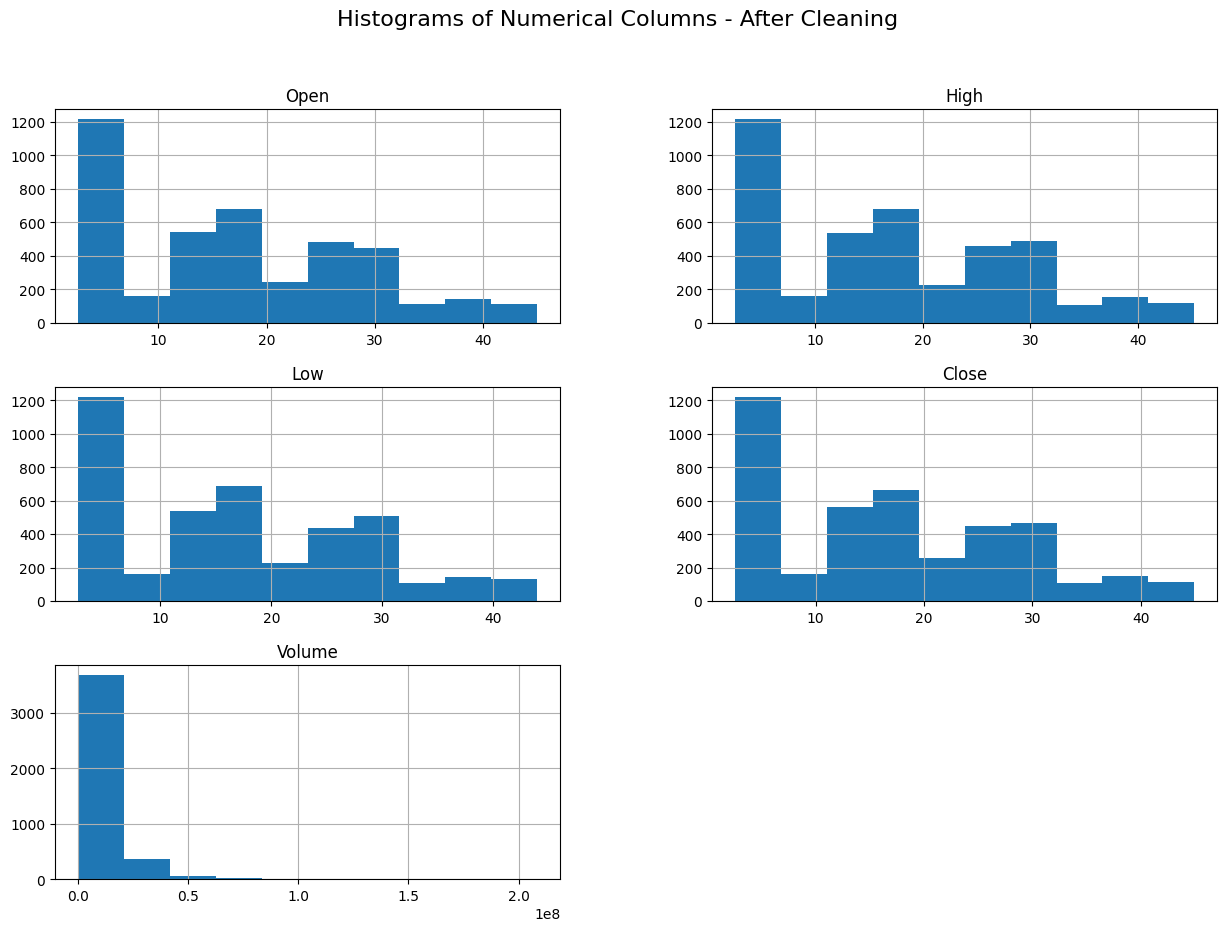

In [16]:
# Plotting histograms for numerical columns to understand their distribution
df.hist(figsize=(15, 10))
plt.suptitle("Histograms of Numerical Columns - After Cleaning", fontsize=16)
plt.show()

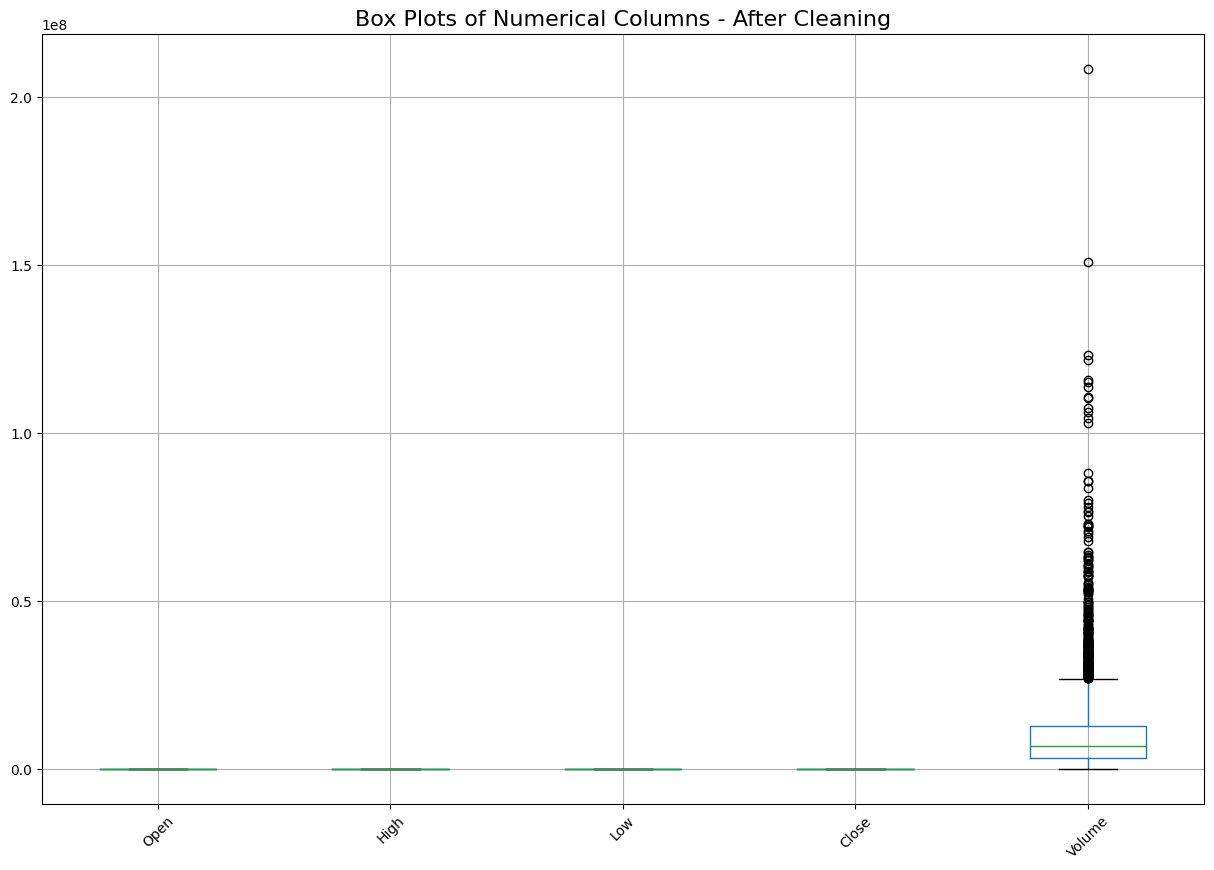

In [17]:
# Box plots to identify outliers
plt.figure(figsize=(15, 10))
df.boxplot()
plt.title("Box Plots of Numerical Columns - After Cleaning", fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Feature Engineering Functions

In [18]:
def calculate_moving_averages(df, windows=[5, 20, 50]):
    for window in windows:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

In [20]:
def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avg_gain = up.rolling(window=period).mean()
    avg_loss = abs(down.rolling(window=period).mean())

    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    df['RSI'] = rsi
    return df

In [22]:
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = df['Close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['Close'].ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    df['MACD'] = signal  # Assuming that we want to store the signal line as MACD
    df['Signal'] = signal
    return df

In [23]:
def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i-1]:
            obv.append(obv[-1] + df['Volume'][i])
        elif df['Close'][i] < df['Close'][i-1]:
            obv.append(obv[-1] - df['Volume'][i])
        else:
            obv.append(obv[-1])
    df['OBV'] = obv
    return df

In [24]:
def create_lagged_prices(df, lags=3):
    for i in range(1, lags + 1):
        df[f'Lag_{i}'] = df['Close'].shift(i)  # Use 'Close' instead of ' Close'
    return df

# Applying Feature Engineering Functions to the DataFrame

In [26]:
df = calculate_moving_averages(df)
df = calculate_rsi(df)
df = calculate_macd(df)
df = calculate_obv(df)
df = create_lagged_prices(df)

<ipython-input-23-11ea6e3d800e>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Close'][i] > df['Close'][i-1]:
<ipython-input-23-11ea6e3d800e>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obv.append(obv[-1] + df['Volume'][i])
<ipython-input-23-11ea6e3d800e>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['Close'][i] < df['Close'][i-1]:
<ipython-input-23-11ea6e3d800e>:7: FutureWarning: Series.__getitem__ treating

# Drop rows with NaN values created by feature engineering

In [28]:
df = df.dropna()

# Display the first few rows with the new features

In [29]:
print("First few rows with engineered features:\n", df.head())

First few rows with engineered features:
             Open  High  Low  Close    Volume  MA_5   MA_20  MA_50        RSI  \
Date                                                                           
2008-09-16  5.05   4.8  4.8    4.8  48811008  5.10  5.4175  5.830   5.263158   
2008-09-17  4.80   4.8  4.8    4.8   7311703  5.01  5.3675  5.790   5.263158   
2008-09-18  4.80   4.9  4.9    4.9  34873578  4.95  5.3225  5.749  16.666667   
2008-09-19  4.90   4.9  4.9    4.9  32336641  4.89  5.2800  5.709  18.750000   
2008-09-22  4.90   5.0  5.0    5.0  19357100  4.88  5.2450  5.672  27.777778   

                MACD    Signal        OBV  Lag_1  Lag_2  Lag_3  
Date                                                            
2008-09-16 -0.194836 -0.194836 -395295337   5.05   5.20   5.20  
2008-09-17 -0.204046 -0.204046 -395295337   4.80   5.05   5.20  
2008-09-18 -0.211927 -0.211927 -360421759   4.80   4.80   5.05  
2008-09-19 -0.218079 -0.218079 -360421759   4.90   4.80   4.80  
2008-09

# Correlation matrix of the features

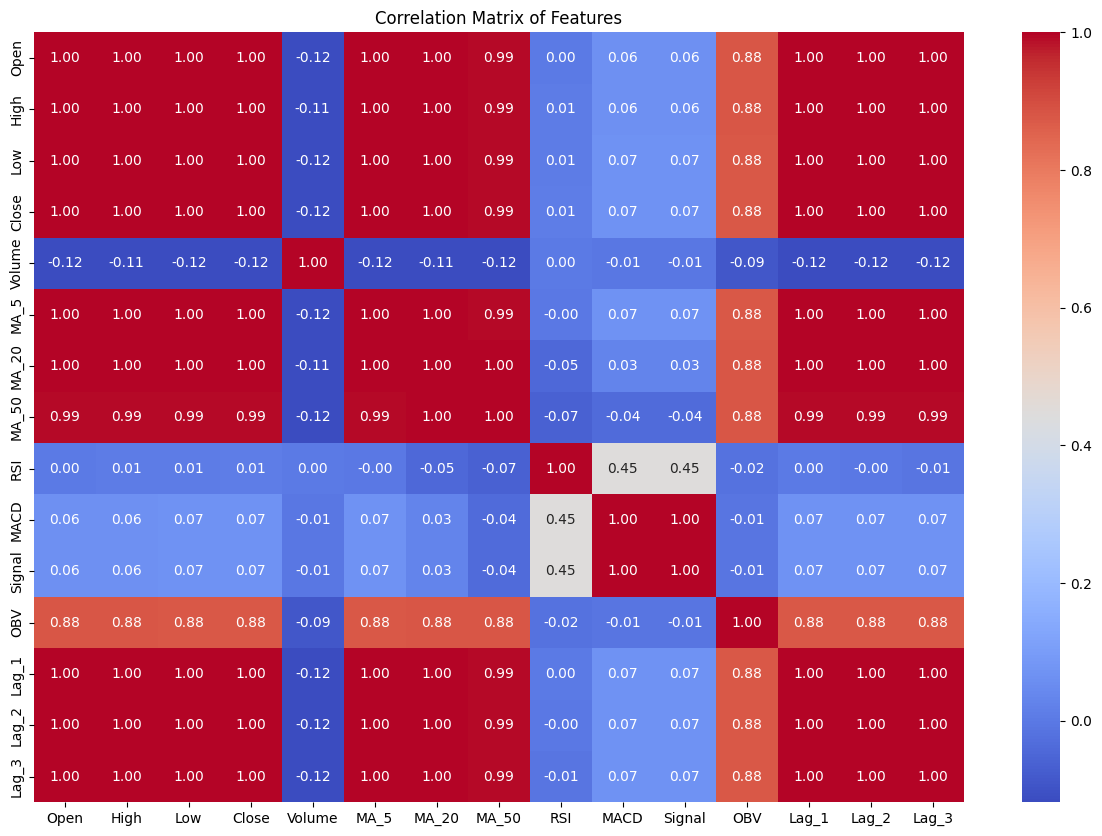

In [30]:
correlation_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

# Plotting a few of the engineered features

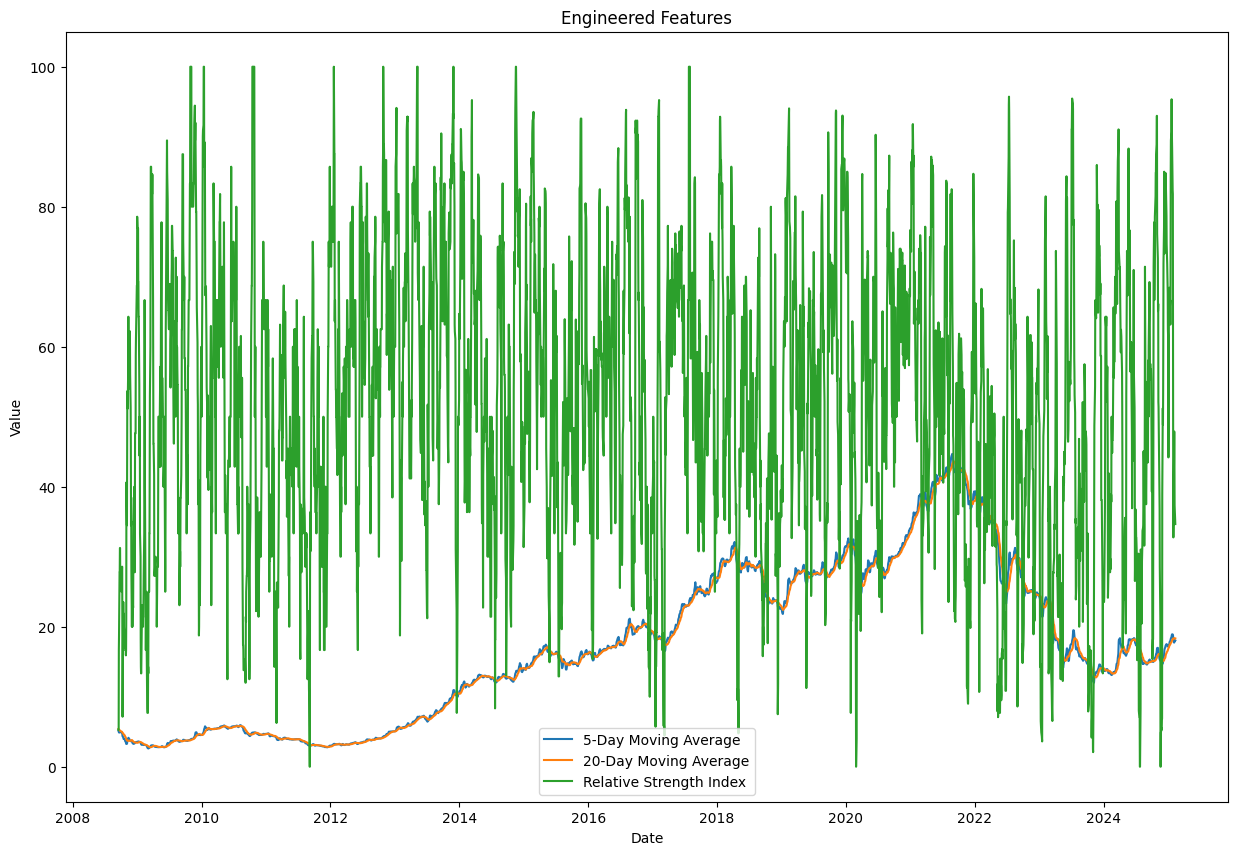

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(df['MA_5'], label='5-Day Moving Average')
plt.plot(df['MA_20'], label='20-Day Moving Average')
plt.plot(df['RSI'], label='Relative Strength Index')
plt.title('Engineered Features')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Model Selection and Training

In [33]:
# Preparing the data for machine learning
X = df.drop('Close', axis=1)  # Features
y = df['Close']  # Target variable

In [35]:
from sklearn.model_selection import train_test_split

# Preparing the data for machine learning
X = df.drop('Close', axis=1)  # Features
y = df['Close']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(3279, 14)
(820, 14)


In [38]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshaping for LSTM/GRU (sample, time steps, features)

In [39]:
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [40]:
print(X_train_rnn.shape)
print(X_test_rnn.shape)

(3279, 1, 14)
(820, 1, 14)


# 1. LSTM Model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [45]:
# Train the LSTM model
lstm_model.fit(X_train_rnn, y_train, epochs=10, verbose=0)

In [46]:
# Make predictions with LSTM
lstm_predictions = lstm_model.predict(X_test_rnn)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


# 2. Random Forest Model

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [51]:
# Making predictions with Random Forest
rf_predictions = rf_model.predict(X_test)

# 3. SVR Model

In [53]:
from sklearn.svm import SVR

svr_model = SVR()
svr_model.fit(X_train, y_train)

SVR()

In [54]:
# Making predictions with SVR
svr_predictions = svr_model.predict(X_test)

# 4. ARIMA Model
Fitting ARIMA model (example order (5,1,0), to find the optimal order). The challenge here is to pick the right orders for the ARIMA model.

In [58]:
!pip install statsmodels

In [59]:
from statsmodels.tsa.arima.model import ARIMA

try:
    # Assuming 'data' should be 'df'
    arima_model = ARIMA(df['Close'], order=(5, 1, 0))
    arima_fit = arima_model.fit()
    arima_predictions = arima_fit.predict(start=len(y_train), end=len(df)-1)
except Exception as e:
    print(f"ARIMA model fitting failed: {e}")
    arima_predictions = np.zeros(len(y_test))  # Dummy prediction if the model doesn't work

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# 5. Prophet Model

In [61]:
# Preparing data in the required Prophet format
prophet_data = df[['Close']].reset_index() # Changed 'data' to 'df'
prophet_data = prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'})

In [64]:
# Create and fit (on the training data) the Prophet model
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(prophet_data[:-len(y_test)])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0c3y6gxf/3e3jv2mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0c3y6gxf/wo9ypfu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69861', 'data', 'file=/tmp/tmp0c3y6gxf/3e3jv2mr.json', 'init=/tmp/tmp0c3y6gxf/wo9ypfu8.json', 'output', 'file=/tmp/tmp0c3y6gxf/prophet_modelg4a8q_6u/prophet_model-20250319083631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [66]:
# Making future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(y_test))
prophet_forecast = prophet_model.predict(future)

In [67]:
# Extracting predictions for the test period
prophet_predictions = prophet_forecast['yhat'][len(prophet_data)-len(y_test):].values

# Performance Evaluation

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def evaluate_model(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    # Calculating directional accuracy
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)

    # Handling cases where diff results in empty arrays
    if len(y_true_diff) == 0 or len(y_pred_diff) == 0:
        directional_accuracy = 0
    else:
        correct_directions = np.sum(np.sign(y_true_diff) == np.sign(y_pred_diff))
        directional_accuracy = (correct_directions / len(y_true_diff)) * 100

    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, Directional Accuracy: {directional_accuracy:.2f}%")
    return rmse, mape, directional_accuracy

In [77]:
# Make predictions with LSTM
lstm_predictions = lstm_model.predict(X_test_rnn)
lstm_predictions = lstm_predictions.flatten() #Reshaping predictions to 1D array

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [78]:
# Evaluating Random Forest
rf_rmse, rf_mape, rf_da = evaluate_model(y_test, rf_predictions, "Random Forest")

Random Forest - RMSE: 0.28, MAPE: 0.84%, Directional Accuracy: 75.58%


In [79]:
# Evaluating SVR
svr_rmse, svr_mape, svr_da = evaluate_model(y_test, svr_predictions, "SVR")

SVR - RMSE: 0.83, MAPE: 2.24%, Directional Accuracy: 73.50%


In [80]:
# Evaluating ARIMA
arima_rmse, arima_mape, arima_da = evaluate_model(y_test, arima_predictions, "ARIMA")

ARIMA - RMSE: 0.42, MAPE: 1.32%, Directional Accuracy: 57.14%


In [81]:
# Evaluating Prophet
prophet_rmse, prophet_mape, prophet_da = evaluate_model(y_test, prophet_predictions, "Prophet")

Prophet - RMSE: 28.61, MAPE: 152.07%, Directional Accuracy: 43.22%


# Investment Strategy Simulation and Backtesting

# *TakingRandom Forest as the best model based on initial metrics we have calculated.*

In [82]:
def backtest_strategy(data, predictions, initial_capital=100000, transaction_cost=0.001):  # Transaction cost is 0.1%
    capital = initial_capital
    holdings = 0
    transactions = []

    for i in range(1, len(predictions)):
        # Generating trading signal based on predicted price movement
        if predictions[i] > predictions[i-1]:  #Expects to increase -> buy
            signal = 1  # Buy signal
        elif predictions[i] < predictions[i-1]: #Expects to decrease -> sell
            signal = -1  # Sell signal
        else:
            signal = 0  # Hold signal

        # Execute trading strategy
        if signal == 1 and capital > 0:
            # Buy as many shares as possible with available capital
            shares_to_buy = int(capital / (data['Close'].iloc[len(data)-len(predictions)+i] * (1 + transaction_cost)))  # Use .iloc to access by position
            if shares_to_buy > 0:
                cost = shares_to_buy * data['Close'].iloc[len(data)-len(predictions)+i] * (1 + transaction_cost)
                capital -= cost
                holdings += shares_to_buy
                transactions.append({'Date': data.index[len(data)-len(predictions)+i], 'Action': 'Buy', 'Shares': shares_to_buy, 'Price': data['Close'].iloc[len(data)-len(predictions)+i], 'Cost': cost, 'Capital': capital, 'Holdings': holdings})
        elif signal == -1 and holdings > 0:
            # Sell all holdings
            revenue = holdings * data['Close'].iloc[len(data)-len(predictions)+i] * (1 - transaction_cost)
            capital += revenue
            transactions.append({'Date': data.index[len(data)-len(predictions)+i], 'Action': 'Sell', 'Shares': holdings, 'Price': data['Close'].iloc[len(data)-len(predictions)+i], 'Revenue': revenue, 'Capital': capital, 'Holdings': 0})
            holdings = 0

    # Calculating final portfolio value
    final_portfolio_value = capital + holdings * data['Close'].iloc[-1]

    # Calculating total return
    total_return = (final_portfolio_value - initial_capital) / initial_capital

    # Converting transactions to DataFrame
    transactions_df = pd.DataFrame(transactions)

    return total_return, transactions_df, final_portfolio_value

# Backtesting the Random Forest strategy

In [84]:
total_return, transactions_df, final_portfolio_value = backtest_strategy(df.copy(), rf_predictions) #Passing a copy to avoid modifying the original dataframe


In [85]:
print(f"Total Return: {total_return:.2f}")
print(f"Final Portfolio Value: {final_portfolio_value:.2f}")
print("\nTransactions:")
print(transactions_df)

Total Return: 2.73
Final Portfolio Value: 372770.52

Transactions:
          Date Action  Shares  Price          Cost       Capital  Holdings  \
0   2021-10-27    Buy    2378  42.00   99975.87600      24.12400      2378   
1   2021-10-29   Sell    2378  42.80           NaN  101700.74560         0   
2   2021-11-10    Buy    2508  40.50  101675.57400      25.17160      2508   
3   2021-11-11   Sell    2508  40.50           NaN  101497.59760         0   
4   2021-11-12    Buy    2522  40.20  101485.78440      11.81320      2522   
..         ...    ...     ...    ...           ...           ...       ...   
304 2025-01-30    Buy   21100  17.70  373843.47000       3.46010     21100   
305 2025-01-31   Sell   21100  17.20           NaN  362560.54010         0   
306 2025-02-03    Buy   20579  17.60  362552.59040       7.94970     20579   
307 2025-02-06   Sell   20579  18.15           NaN  373143.29085         0   
308 2025-02-11    Buy   21001  17.75  373140.51775       2.77310     21001 

# Calculating Sharpe Ratio (simplified - assumes risk-free rate of 0)

In [86]:
#We will need to get daily returns.
daily_returns = transactions_df.Revenue.fillna(0)-transactions_df.Cost.fillna(0)
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) if np.std(daily_returns) > 0 else 0
print(f"\nSharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: -0.00


# Calculating Maximum Drawdown which requires iterating through portfolio value.

In [90]:
portfolio_values = [100000]
capital = 100000
holdings = 0

for i in range(1, len(rf_predictions)):
    if rf_predictions[i] > rf_predictions[i-1]:
        signal = 1
    elif rf_predictions[i] < rf_predictions[i-1]:
        signal = -1
    else:
        signal = 0

    if signal == 1 and capital > 0:
        shares_to_buy = int(capital / (df['Close'].iloc[len(df)-len(rf_predictions)+i] * 1.001))
        if shares_to_buy > 0:
            cost = shares_to_buy * df['Close'].iloc[len(df)-len(rf_predictions)+i] * 1.001
            capital -= cost
            holdings += shares_to_buy
    elif signal == -1 and holdings > 0:
        revenue = holdings * df['Close'].iloc[len(df)-len(rf_predictions)+i] * 0.999
        capital += revenue
        holdings = 0
    portfolio_values.append(capital + holdings * df['Close'].iloc[len(df)-len(rf_predictions)+i])

portfolio_values = np.array(portfolio_values)
peak = np.maximum.accumulate(portfolio_values)
drawdown = (portfolio_values - peak) / peak
max_drawdown = np.min(drawdown)

print(f"Maximum Drawdown: {max_drawdown:.2f}")

Maximum Drawdown: -0.18


# Plotting Actual vs Predicted Stock Prices

In [92]:
# Creating a date range for the predicted values
prediction_dates = df.index[-len(y_test):]

In [93]:
# Plotting the data
plt.figure(figsize=(15, 7))

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

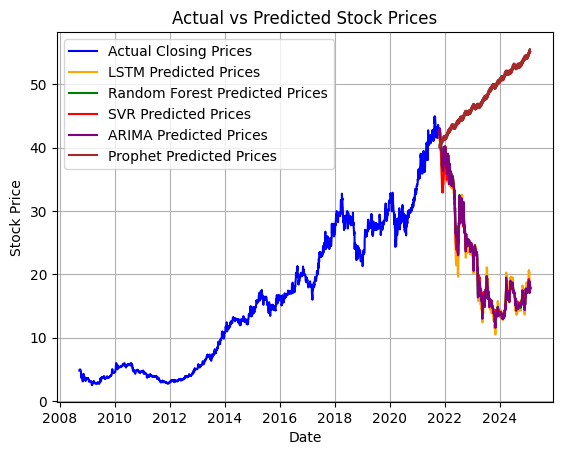

In [97]:
# Plotting actual closing prices
plt.plot(df.index, df['Close'], label='Actual Closing Prices', color='blue')

# Plotting predicted prices for each model
plt.plot(prediction_dates, lstm_predictions, label='LSTM Predicted Prices', color='orange')
plt.plot(prediction_dates, rf_predictions, label='Random Forest Predicted Prices', color='green')
plt.plot(prediction_dates, svr_predictions, label='SVR Predicted Prices', color='red')
plt.plot(prediction_dates, arima_predictions, label='ARIMA Predicted Prices', color='purple')
plt.plot(prediction_dates, prophet_predictions, label='Prophet Predicted Prices', color='brown')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()